## SME0828 - Introdução à Ciência de Dados

Aluno: Natan Henrique Sanches (11795680)

Entrega 4 - Classificador Bayesiano

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal

#### Interface dos Classificadores Bayesianos

In [159]:
class ParametricBC():
    def __init__(self, classes):
        self.P = None
        self.means = []
        self.covs = []
        self.classes = classes
        self.P_classes = np.zeros(len(self.classes))


    def fit(self, X_train, y_train):
        P_class = np.zeros(len(self.classes))
        for i in range(0, len(self.classes)):
            elements = tuple(np.where(y_train == self.classes[i]))
            self.P_classes[i] = len(elements[0])/len(y_train)
            elements_features = X_train[elements,:][0]
            self.means.append(np.mean(elements_features, axis=0))
            self.covs.append(np.cov(np.transpose(elements_features)))


    def predict(self, X_test):
        self.P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(self.classes))), 
                            columns=classes)
        for i in range(0, len(self.classes)):
            for j in range(0, X_test.shape[0]):
                P_j = multivariate_normal.pdf(X_test[j,:], mean=self.means[i], 
                                            cov=self.covs[i], allow_singular=True)
                self.P[classes[i]][j] = self.P_classes[i] * P_j

        y_pred = []
        for i in range(0, X_test.shape[0]):
            cl = np.argmax(np.array(self.P.iloc[[i]]))
            y_pred.append(self.classes[cl])
        return np.array(y_pred, dtype=str)


    def get_test_probability_matrix(self):
        return self.P


In [193]:
class NonParametricBC():
    def __init__(self, classes):
        self.P = None
        self.elements_features = []
        self.classes = classes
        self.P_classes = np.zeros(len(self.classes))
    

    def split_classes(self, X_train, y_train,):
        self.P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(self.classes))),
                              columns=self.classes)
        for i in range(0, len(self.classes)):
            elements = np.where(y_train == self.classes[i])[0]
            self.P_classes[i] = len(elements)/len(y_train)
            self.elements_features.append(X_train[elements,:])


    # simply don't know why I can't put model_kernel in split_classes function
    # (as if a 'fit' function) -- as did in ParametricBC -- without the kernel's
    # 'score_samples' returning wrong values
    def predict(self, X_test, bandwidth=1, kernel='gaussian'):
        for i in range(0, len(classes)):
            model_kernel = KernelDensity(kernel=kernel, bandwidth=bandwidth)\
                           .fit(self.elements_features[i])
            for j in range(0, X_test.shape[0]):
                sample = X_test[j,:].reshape((1, len(X_test[j,:])))
                P_sample = np.exp(model_kernel.score_samples(sample))
                self.P[self.classes[i]][j] = self.P_classes[i] * P_sample

        y_pred = []
        for i in range(0, X_test.shape[0]):
            cl = np.argmax(np.array(self.P.iloc[[i]]))
            y_pred.append(self.classes[cl])
        return np.array(y_pred, dtype=str)


    def get_test_probability_matrix(self): 
        return self.P

#### 1. Considerando a base de dados Vehicle, encontre o melhor classificador dentre os métodos k-vizinhos, Naive Bayes, regressão logística, classificador Bayesiano e classificador Bayesino não-paramétrico.

In [161]:
df = pd.read_csv('drive/MyDrive/data/Vehicle.csv')

df

,Comp,Circ,D.Circ,Rad.Ra,Pr.Axis.Ra,Max.L.Ra,Scat.Ra,Elong,Pr.Axis.Rect,Max.L.Rect,Sc.Var.Maxis,Sc.Var.maxis,Ra.Gyr,Skew.Maxis,Skew.maxis,Kurt.maxis,Kurt.Maxis,Holl.Ra,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,93,39,87,183,64,8,169,40,20,134,200,422,149,72,7,25,188,195,saab
842,89,46,84,163,66,11,159,43,20,159,173,368,176,72,1,20,186,197,van
843,106,54,101,222,67,12,222,30,25,173,228,721,200,70,3,4,187,201,saab
844,86,36,78,146,58,7,135,50,18,124,155,270,148,66,0,25,190,195,saab


In [162]:
X = df.loc[:,df.columns != 'Class']
y = df['Class']

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [163]:
acc_scores = {}

**K-Nearest Neighbors**

In [164]:
folds = 5
scores = []

for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    cv = cross_validate(model, X_train, y_train, cv=folds)
    scores.append(cv['test_score'].mean())

best_k = np.argmax(scores)+1
best_k

1

In [165]:
model = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_scores['KNN'] = accuracy_score(y_pred, y_test)
print('Acurácia (KNN): ' + str(acc_scores['KNN']))

Acurácia (KNN): 0.6823529411764706


**Regressão Logística**

In [166]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_scores['LogReg'] = accuracy_score(y_pred, y_test)
print('Acurácia (LogReg): ' + str(acc_scores['LogReg']))

Acurácia (LogReg): 0.7764705882352941


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


**Classificador Bayesiano (paramétrico)**

In [167]:
classes = np.array(pd.unique(df[df.columns[-1]]))
classes

array(['van', 'saab', 'bus', 'opel'], dtype=object)

In [168]:
model = ParametricBC(classes)
model.fit(X_train, y_train)

In [169]:
y_pred = model.predict(X_test)
acc_scores['BCParametric'] = accuracy_score(y_pred, y_test)
print('Acurácia (BCParametric): ' + str(acc_scores['BCParametric']))

Acurácia (BCParametric): 0.8235294117647058


In [170]:
P = model.get_test_probability_matrix()
P

,van,saab,bus,opel
0,4.586208e-02,6.345643e-32,5.847533e-21,4.813204e-30
1,0.000000e+00,2.913600e-01,2.305646e-18,3.667014e+00
2,1.913332e-06,4.104589e-04,3.431842e-01,1.704936e-03
3,7.977356e-06,3.235217e-05,1.065028e+00,5.677494e-04
4,1.641390e-07,1.897056e-06,1.052572e+01,1.716363e-06
...,...,...,...,...
165,1.440855e-11,9.723825e-10,1.531523e-03,1.175778e-11
166,0.000000e+00,1.285377e-04,6.352446e-30,1.471767e-01
167,5.649878e-05,1.266934e-06,1.534529e+01,4.527917e-06
168,2.372904e-104,5.507079e-17,2.352723e-02,7.348969e-13


**Classificador Bayesiano (não-paramétrico)**

In [171]:
model = NonParametricBC(classes)
model.split_classes(X_train, y_train)

In [172]:
y_pred = model.predict(X_test, bandwidth=1)
acc_scores['BCNonParametric'] = accuracy_score(y_pred, y_test)
print('Acurácia (BCNonParametric): ' + str(acc_scores['BCNonParametric']))

Acurácia (BCNonParametric): 0.6823529411764706


In [173]:
P = model.get_test_probability_matrix()
P

,van,saab,bus,opel
0,3.113735e-10,4.302327e-11,4.544450e-11,1.671954e-11
1,2.340995e-14,7.108293e-10,3.872583e-11,8.937612e-10
2,2.315333e-10,1.472671e-10,1.171693e-09,4.622988e-11
3,1.339672e-10,1.069966e-10,1.476351e-09,4.913895e-11
4,7.368705e-11,7.486966e-11,1.889986e-09,3.412683e-11
...,...,...,...,...
165,4.143924e-11,6.969583e-11,6.848203e-10,1.051592e-11
166,4.219769e-15,2.889084e-10,6.691969e-12,6.204299e-10
167,4.220661e-10,1.254572e-10,1.237180e-09,4.701021e-11
168,1.173770e-11,6.531898e-11,4.284999e-10,3.866572e-11


**Naive-Bayes (Gaussiano)** 

In [174]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_scores['NB-Gaussian'] = accuracy_score(y_pred, y_test)
print('Acurácia (NB-Gaussian): ' + str(acc_scores['NB-Gaussian']))

Acurácia (NB-Gaussian): 0.4117647058823529


**Naive-Bayes (Bernoulli)**

In [175]:
model = BernoulliNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_scores['NB-Bernoulli'] = accuracy_score(y_pred, y_test)
print('Acurácia (NB-Bernoulli): ' + str(acc_scores['NB-Bernoulli']))

Acurácia (NB-Bernoulli): 0.4470588235294118


In [176]:
print('Em ordem decrescente (do melhor para o pior):', end='\n\n')
sorted(acc_scores, key=lambda x: acc_scores[x], reverse=True)

Em ordem decrescente (do melhor para o pior):



['BCParametric',
 'LogReg',
 'KNN',
 'BCNonParametric',
 'NB-Bernoulli',
 'NB-Gaussian']

#### 2. Considerando a base de dados “winequality-red”, encontre o valor do hiperparâmetro h que oferece a maior acurácia no Bayesino não-paramétrico.

In [189]:
df = pd.read_csv('drive/MyDrive/data/winequality-red.csv')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [190]:
X = df.loc[:,df.columns != 'quality']
y = np.array(df['quality'], dtype=str)
classes = np.array(pd.unique(y), dtype=str)

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Text(0, 0.5, 'Acurácia')

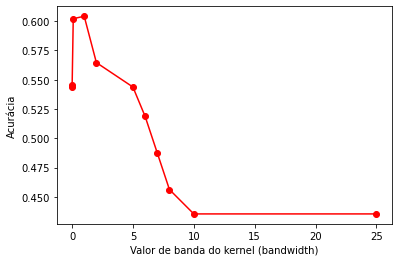

In [191]:
bandwidth_values = [0.001, 0.01, 0.1, 1, 2, 5, 6, 7, 8, 10, 25]
scores = []

for b in bandwidth_values:
    model = NonParametricBC(classes)
    model.split_classes(X_train, y_train)
    y_pred = model.predict(X_test, bandwidth=b)
    scores.append(accuracy_score(y_pred, y_test))

plt.plot(bandwidth_values, scores, 'o-', color='red')
plt.xlabel('Valor de banda do kernel (bandwidth)')
plt.ylabel('Acurácia')

In [192]:
best_bandwidth = bandwidth_values[np.argmax(scores)]
print(f'O melhor valor para o hiperparâmetro, nos testes feitos, é {best_bandwidth}')
print(f'A acurácia com bandwidth={best_bandwidth} foi de {max(scores)}')

O melhor valor para o hiperparâmetro, nos testes feitos, é 1
A acurácia com bandwidth=1 foi de 0.6041666666666666


#### 3. Faça a classificação dos dados gerados artificialmente com o código abaixo. Compare os resultados para os métodos Naive Bayes, Classificador Bayesiano paramétrico e o classificador Bayesiano não-paramétrico (escolha um valor para h).

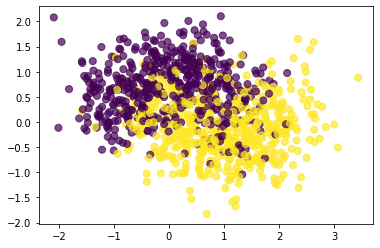

In [181]:
plt.figure(figsize=(6,4))
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.5)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

In [182]:
y = np.array(y, dtype=str)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
classes = np.array(pd.unique(y_test))
classes

array(['1', '0'], dtype='<U21')

In [183]:
acc_scores = {}

**Classificador Bayesiano (paramétrico)**

In [184]:
model = ParametricBC(classes)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_scores['ParametricBC'] = accuracy_score(y_pred, y_test)
print('Acurácia (ParametricBC): ' + str(acc_scores['ParametricBC']))

Acurácia (ParametricBC): 0.805


In [185]:
model.get_test_probability_matrix()

,1,0
0,0.063239,0.001190
1,0.127079,0.081785
2,0.007033,0.010329
3,0.039269,0.044352
4,0.080050,0.038979
...,...,...
195,0.086110,0.060086
196,0.107470,0.034328
197,0.044609,0.000742
198,0.044830,0.005674


**Classificador Bayesiano (não-paramétrico)**

Escolhendo $h=2$:

In [186]:
model = NonParametricBC(classes)
model.split_classes(X_train, y_train)
y_pred = model.predict(X_test, bandwidth=2)
acc_scores['NonParametricBC'] = accuracy_score(y_pred, y_test)
print('Acurácia (NonParametricBC): ' + str(acc_scores['NonParametricBC']))

Acurácia (NonParametricBC): 0.76


**Naive Bayes (gaussiano)**

In [187]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_scores['GaussianNB'] = accuracy_score(y_pred, y_test)
print('Acurácia (GaussianNB): ' + str(acc_scores['GaussianNB']))

Acurácia (GaussianNB): 0.8


In [188]:
print('Em ordem decrescente (do melhor para o pior):', end='\n\n')
sorted(acc_scores, key=lambda x: acc_scores[x], reverse=True)

Em ordem decrescente (do melhor para o pior):



['ParametricBC', 'GaussianNB', 'NonParametricBC']